In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
word_with_max_length = max(words, key=len)
print(word_with_max_length)
print(words[:8])

32033
15
muhammadibrahim
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
for i, s in enumerate(chars):
    # print(i, s)
    pass
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(X)
      # print(Y)
      
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [8]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  '''
  Each single sample `x` is a row vector of shape (fan_in). The weight matrix `W` is of shape (fan_in, fan_out).
  Thus, the output of `x @ W` is a row vector of shape (fan_out).
  In practice, the samples are batched, so the input have shape (batch_size, fan_in), and the output has shape (batch_size, fan_out).
  '''
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming init with gain=1
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    '''
    dim: the feature dimension (i.e., the number of features) of a sample.
    '''
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2: # [B, C], i.e., [batch_size, num_features]
        dim = 0 # Batch space: [batch_size]
      elif x.ndim == 3: # [B, T, C], i.e., [batch_size, num_sequences, num_features].
        dim = (0,1) # Batch space: [batch_size, num_sequences]
      xmean = x.mean(dim, keepdim=True) # batch mean. Calculate mean for the whole batch space.
      xvar = x.var(dim, keepdim=True) # batch variance. Calculate (unbiased) variance for the whole batch space.
    else:
      # During inference (i.e., evaluation or testing of the model), you typically process one instance at a time. In this case, we can't compute the unbiased var.
      # As a result, we use the running mean and variance to normalize the data.
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  '''
  A simple lookup table that stores embeddings of a fixed dictionary and size.
  Each input sample is a tensor of indices of shape (batch_size, num_features) and the output is the corresponding embeddings of shape (batch_size, num_features, embedding_dim).
  '''
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    # print(f"IX shape: {IX.shape}")
    # print(f"weight shape: {self.weight.shape}")
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  '''
  To do flattening betwwen layers.
  '''
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1: # If we have only one sequence, squeeze it out. (B, T=1, C) --> (B, C)
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42); # seed rng for reproducibility

In [10]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd), # [B, T] --> [B, T, C]. [32, 8] --> [32, 8, 24]
  
  FlattenConsecutive(2), # [B, T, C] --> [B, T//2, C*2]. [32, 8, 24] --> [32, 4, 48]
  Linear(n_embd * 2, n_hidden, bias=False), # [B, T//2, C*2] --> [B, T//2, H]. [32, 4, 48] --> [32, 4, 128]
  BatchNorm1d(n_hidden), # [B, T//2, H] --> [B, T//2, H]. [32, 4, 128] --> [32, 4, 128]
  Tanh(), # [B, T//2, H] --> [B, T//2, H]. [32, 4, 128] --> [32, 4, 128]
  
  FlattenConsecutive(2), # [B, T//2, H] --> [B, T//4, H*2]. [32, 4, 128] --> [32, 2, 256]
  Linear(n_hidden*2, n_hidden, bias=False), # [B, T//4, H*2] --> [B, T//4, H]. [32, 2, 256] --> [32, 2, 128]
  BatchNorm1d(n_hidden),
  Tanh(),
  
  FlattenConsecutive(2), # [B, T//4, H] --> [B, T//8, H*2] --> [B, H*2]. [32, 2, 128] --> [32, 1, 256] --> [32, 256]
  Linear(n_hidden*2, n_hidden, bias=False), # [B, H*2] --> [B, H]. [32, 256] --> [32, 128]
  BatchNorm1d(n_hidden), 
  Tanh(),
  
  Linear(n_hidden, vocab_size), # [B, H] --> [B, V]. [32, 128] --> [32, 27]

])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [11]:
ix = torch.randint(0, vocab_size, (3,)) # Get a batch of 3 samples. Each sample is a single integer index ranging from 0 to vocab_size-1, used to select one feature in the embedding matrix.
ix.shape
f = Embedding(vocab_size, n_embd)
y = f.__call__(ix)
y.shape

torch.Size([3, 24])

In [12]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # A batch of indices. Each index is a random integer ranging from 0 to Xtr.shape[0]-1.
  
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y. # Each single sample is a context (length=8)
  
  # forward pass
  logits = model(Xb) # Each context (8-D vector) is converted to a 27-D vector.
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2937
  10000/ 200000: 1.5335
  20000/ 200000: 1.9559
  30000/ 200000: 2.0135
  40000/ 200000: 1.6584
  50000/ 200000: 2.2143
  60000/ 200000: 1.7130
  70000/ 200000: 1.6439
  80000/ 200000: 2.0402
  90000/ 200000: 1.3960
 100000/ 200000: 2.0753
 110000/ 200000: 1.8195
 120000/ 200000: 2.1677
 130000/ 200000: 1.9649
 140000/ 200000: 1.7917
 150000/ 200000: 1.9716
 160000/ 200000: 1.4425
 170000/ 200000: 1.5855
 180000/ 200000: 1.6931
 190000/ 200000: 1.5892


In [19]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

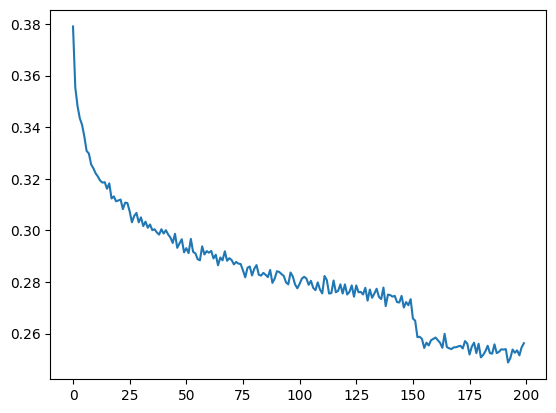

In [20]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [21]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [22]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7674026489257812
val 1.9878350496292114


In [23]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

petra.
semaj.
uthaxb.
valerte.
linlee.
alexzandre.
cainrey.
gila.
lileen.
zenaya.
rhet.
elianna.
kenslein.
shanez.
foxten.
elianna.
analya.
penela.
tavious.
katilina.


In [24]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word


loana.
aysean.
tracin.
demitrius.
nira.
duxia.
lakyla.
jaydance.
enoleisy.
maddael.
khamorah.
suaelle.
arilyn.
kayton.
zansa.
elda.
trenta.
canderson.
luci.
semica.
